
# MNIST Digit Classifier - Interactive Demo

This notebook demonstrates the complete functionality of the MNIST Digit Classification pipeline, including all three model implementations and edge case handling.

---

## Table of Contents

1. [Setup and Imports](#setup)
2. [Data Loading and Exploration](#data-loading)
3. [Model 1: Random Forest Classifier](#random-forest)
4. [Model 2: Feedforward Neural Network](#feedforward-nn)
5. [Model 3: Convolutional Neural Network](#cnn)
6. [Model Comparison](#comparison)
7. [Edge Cases](#edge-cases)
9. [Conclusions](#conclusions)


## 1. Setup and Imports
First, let's import all necessary libraries and configure the environment.

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All imports successful
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1660 SUPER


## 2. Data Loading and Exploration
Let's load the MNIST dataset and explore its properties.

In [146]:
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data
y = mnist.target

print(f"Dataset loaded successfully")
print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Image dimensions: 28×28 = {28*28}")
print(f"Classes: {np.unique(y)}")

Loading MNIST dataset...
Dataset loaded successfully
Dataset shape: (70000, 784)
Number of samples: 70000
Number of features: 784
Image dimensions: 28×28 = 784
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


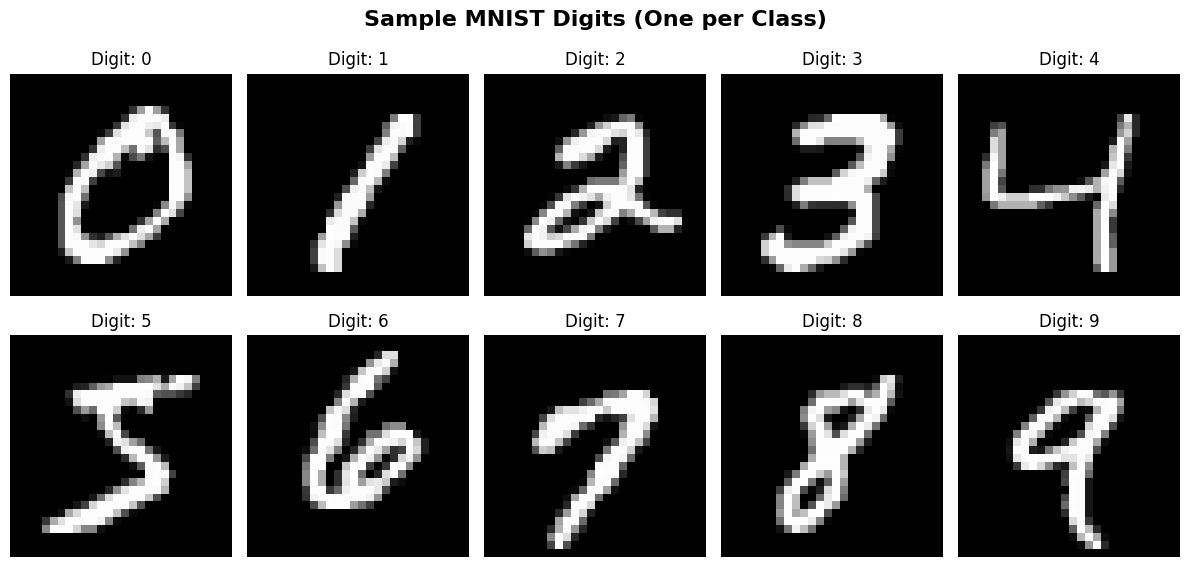

In [147]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Sample MNIST Digits (One per Class)', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    # Find first occurrence of digit
    digit_indices = np.where(y.astype(int) == idx)[0]
    sample_idx = digit_indices[0]
    
    # Reshape and display
    image = X.iloc[sample_idx].values.reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Digit: {idx}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

This section prepares the dataset for training and evaluation:

- Normalization:
Each pixel value in the feature matrix X is divided by 255 to scale it from the range [0, 255] to [0, 1].
Normalization helps neural networks converge faster and prevents numerical instability during training.

- Label Formatting:
The target vector y is explicitly converted to the integer type (int64) to ensure compatibility with PyTorch and scikit-learn models.

- Train–Test Split:
The dataset is divided into training and testing subsets using an 80/20 ratio.
The random_state=42 ensures reproducibility - meaning the same split will occur every time the code runs.

In [148]:
# Normalize pixel values and prepare data
X = X.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(np.int64)  # Convert target to integer type

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)


## 3. Model 1: Random Forest Classifier
Let's train and evaluate a Random Forest classifier as our baseline model.

In [149]:
print("="*80)
print("RANDOM FOREST CLASSIFIER")
print("="*80)

# Initialize and train
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f"Test Accuracy: {rf_accuracy*100:.2f}%")

RANDOM FOREST CLASSIFIER
Test Accuracy: 96.75%


## 4. Model 2: Feedforward Neural Network

In this section, a deep feedforward neural network is defined and prepared for the digit classification task. The model is configured to run on a GPU if one is available; otherwise, it defaults to the CPU. This ensures that training remains efficient and adaptable to different hardware environments.

The architecture consists of several fully connected layers that gradually reduce dimensionality and extract increasingly abstract representations from the 28×28 input images (flattened into 784 features). Each dense layer is followed by batch normalization to stabilize the learning process, a GELU activation function that provides smoother and more expressive nonlinearity, and dropout regularization to prevent overfitting. The final output layer contains 10 neurons corresponding to the 10 digit classes. This combination of normalization, activation, and regularization techniques allows the network to learn robust patterns while maintaining stability during training.

The loss function used is cross-entropy, which is standard for multi-class classification problems. Optimization is performed using the AdamW algorithm, a variant of Adam that decouples weight decay from the gradient update, thereby improving generalization. The learning rate is set to 0.001, with a weight decay of 1e-4 to further reduce overfitting. The model is trained for 50 epochs with a batch size of 256 samples per update, providing a good balance between convergence speed and stability. The total number of trainable parameters is also computed, reflecting the overall capacity and complexity of the network.

In [150]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.Sequential(
    nn.Linear(784, 700),
    nn.BatchNorm1d(700),
    nn.GELU(),
    nn.Dropout(0.2),

    nn.Linear(700, 700),
    nn.BatchNorm1d(700),
    nn.GELU(),
    nn.Dropout(0.2),

    nn.Linear(700, 350),
    nn.BatchNorm1d(350),
    nn.GELU(),
    nn.Dropout(0.2),

    nn.Linear(350, 256),
    nn.BatchNorm1d(256),
    nn.GELU(),
    nn.Dropout(0.1),
        
    nn.Linear(256, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.001,
    weight_decay=1e-4
    )

epochs = 50
batch_size = 256
nn_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

This function performs inference using the trained neural network model on a given test dataset. It begins by printing a message to indicate the start of the prediction process. The input data X_test is checked to determine whether it is a pandas DataFrame or a NumPy array. If it is a DataFrame, it is converted to a NumPy array to ensure compatibility with PyTorch tensors. The data is then transformed into a torch.tensor of type float32, which matches the input format expected by the model.

Before prediction, the model is switched to evaluation mode (model.eval()), disabling training-specific operations such as dropout and batch normalization updates to ensure consistent output behavior. The function processes the test data in batches of 1000 samples to optimize memory usage and improve computational efficiency, especially on large datasets.

Within a torch.no_grad() context (which prevents gradient calculations and saves memory), each batch is transferred to the appropriate device-either the GPU or CPU. The model then produces output logits for each sample in the batch, and the torch.max() function extracts the class with the highest predicted probability. These predicted labels are collected and appended to a list.

If running on a GPU, the function also clears unused memory (torch.cuda.empty_cache()) after each batch to avoid potential memory overflow. Once all data has been processed, it prints a completion message and returns the final predictions as a NumPy array.

Overall, this function efficiently handles batch inference with proper device management, ensuring stability and scalability even for large datasets.

In [151]:

def predict_nn(X_test):
    print("Starting prediction...")
    # Convert to numpy if DataFrame
    X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
   
    X_test_tensor = torch.tensor(
        X_test_np, 
        dtype=torch.float32
    )
    
    model.eval()
    predictions = []
    batch_size = 1000
    
    with torch.no_grad():
        for i in range(0, len(X_test_tensor), batch_size):
            batch = X_test_tensor[i:i+batch_size].to(device)
            outputs = model(batch)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

            if device.type == 'cuda':
                torch.cuda.empty_cache()
    
    print("Prediction complete")
    return np.array(predictions)


This code segment prepares the data for training and validating a neural network model by creating a proper split and converting it into PyTorch-compatible tensor formats.

First, the existing training set is further divided into two subsets - a new training set and a validation set = using an additional train_test_split operation. Ten percent of the original training data is reserved for validation (test_size=0.1), ensuring that the model’s performance can be monitored on unseen data during training. The random_state=42 parameter guarantees reproducibility of the split.

Next, the code checks whether the resulting data (X_train_new, X_val_new, y_train_new, and y_val_new) are pandas DataFrames or NumPy arrays. If they are DataFrames, the .values attribute is used to extract their underlying NumPy arrays, ensuring consistent handling regardless of the input type.

Since this model is a multilayer perceptron (MLP), which expects flat input vectors rather than images, no reshaping is required - each sample remains as a one-dimensional array of 784 features (corresponding to 28×28 pixels).

In [152]:
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42,
)
X_train_np = X_train_new.values if hasattr(X_train_new, 'values') else X_train_new
X_val_np = X_val_new.values if hasattr(X_val_new, 'values') else X_val_new
y_train_np = y_train_new.values if hasattr(y_train_new, 'values') else y_train_new
y_val_np = y_val_new.values if hasattr(y_val_new, 'values') else y_val_new
# No reshape needed for MLP, keep as (N, 784)
X_train_tensor = torch.tensor(
    X_train_np, 
    dtype=torch.float32
)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)

X_val_tensor = torch.tensor(
    X_val_np, 
    dtype=torch.float32
).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long).to(device)

This code sets up the training data pipeline and learning rate scheduling for a neural network, along with variables for early stopping.

First, a DataLoader is created to efficiently handle the training data in mini-batches. The TensorDataset wraps the feature and label tensors (X_train_tensor and y_train_tensor) into a single dataset object, which the DataLoader then splits into batches of size 128. Shuffling is enabled to ensure that each epoch sees the training samples in a different order, improving generalization. The total number of steps per epoch is computed from the length of the dataloader.

Next, a One Cycle Learning Rate scheduler is configured. The maximum learning rate is set to ten times the base rate (max_lr = 0.001 * 10). The scheduler adjusts the learning rate dynamically during training according to the One Cycle policy: it increases initially for 30% of the cycle (pct_start=0.3) and then decays following a cosine annealing strategy (anneal_strategy='cos'). This technique often improves convergence speed and final accuracy.

Finally, variables are initialized to support early stopping. best_loss tracks the lowest validation loss observed, patience defines the number of epochs to wait for improvement before stopping, patience_counter keeps count of consecutive epochs without improvement, and best_model_state will store the parameters of the model corresponding to the best observed validation loss.

In [153]:
# DataLoader 
batch_size = 128
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
steps_per_epoch = len(dataloader)
max_lr = 0.001 * 10

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.3,
    anneal_strategy='cos',
)

best_loss = float('inf')
patience = 15
patience_counter = 0
best_model_state = None

This block implements the main training loop for the neural network. For each epoch, the model is set to training mode, and the code iterates over batches from the DataLoader. Each batch is moved to the correct device, the optimizer gradients are reset, and the model computes outputs and loss. Backpropagation is performed, gradients are optionally clipped for stability, and the optimizer updates the model parameters. The learning rate scheduler is also stepped each batch. Training loss and accuracy are accumulated to track performance.

After each epoch, the model is evaluated on the validation set without gradient computation. Validation loss and accuracy are calculated, and early stopping logic checks if the validation loss improved. If no improvement occurs for a defined number of epochs (patience), training stops early. Periodic progress is printed every 5 epochs or upon early stopping.

Finally, if a best model state was saved during training, it is loaded back into the model to ensure the network reflects the best validation performance. Memory is cleared on the GPU after each epoch to prevent overflow.

In [ ]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
            
    for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
        # Move batch to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step() 

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
             
        avg_train_loss = epoch_loss / len(dataloader)
        train_accuracy = 100 * correct / total
        # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        _, val_preds = torch.max(val_outputs, 1)
        val_acc = 100 * (val_preds == y_val_tensor).sum().item() / len(y_val_tensor)
                
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
            
    if (epoch + 1) % 5 == 0 or patience_counter == patience:
        print(f"Epoch [{epoch+1}/{epochs}] "
                f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.2f}% | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Clear cache if using CUDA
    if device.type == 'cuda':
        torch.cuda.empty_cache()

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model from training")

Epoch [5/50] Train Loss: 0.0848, Acc: 97.30% | Val Loss: 0.1063, Val Acc: 96.71%
Epoch [10/50] Train Loss: 0.0567, Acc: 98.25% | Val Loss: 0.0787, Val Acc: 97.71%
Epoch [15/50] Train Loss: 0.0385, Acc: 98.78% | Val Loss: 0.0774, Val Acc: 97.82%
Epoch [20/50] Train Loss: 0.0270, Acc: 99.11% | Val Loss: 0.0686, Val Acc: 98.14%
Epoch [25/50] Train Loss: 0.0184, Acc: 99.40% | Val Loss: 0.0684, Val Acc: 98.43%
Epoch [29/50] Train Loss: 0.0117, Acc: 99.62% | Val Loss: 0.0710, Val Acc: 98.36%
Early stopping at epoch 29
Loaded best model from training


And after all of this we can do predictions on the new data samplings. 

In [155]:
nn_predictions = predict_nn(X_test)
nn_accuracy = accuracy_score(y_test, nn_predictions)
print(f"Test Accuracy: {nn_accuracy*100:.2f}%")

Starting prediction...
Prediction complete
Test Accuracy: 98.38%


## 5. Model 3: Convolutional Neural Network
Next to train is a CNN - the state-of-the-art approach for image classification.

In [156]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.Sequential(
# First conv block: 1 -> 32 channels
nn.Conv2d(1, 32, kernel_size=3, padding=1),
nn.BatchNorm2d(32),
nn.GELU(),
nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
nn.Dropout2d(0.2),
            
# Second conv block: 32 -> 64 channels
nn.Conv2d(32, 64, kernel_size=3, padding=1),
nn.BatchNorm2d(64),
nn.GELU(),
nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
nn.Dropout2d(0.2), 
# Flatten
nn.Flatten(), 
# Fully connected layers
nn.Linear(64 * 7 * 7, 128),
nn.GELU(),
nn.Dropout(0.1),
nn.Linear(128, 10)  # 10 classes for MNIST
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
        patience=3,
    )

epochs = 50
batch_size = 256
cnn_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [157]:
X_train_tensor = torch.tensor(
    X_train_np.reshape(-1, 1, 28, 28), 
    dtype=torch.float32
    )
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
        
X_val_tensor = torch.tensor(
    X_val_np.reshape(-1, 1, 28, 28), 
    dtype=torch.float32
).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long).to(device)

In [158]:
# DataLoader 
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=4, 
    pin_memory=True if device.type == 'cuda' else False
)

best_loss = float('inf')
patience = 15
patience_counter = 0
best_model_state = None

In [159]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
        # Move batch to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    avg_train_loss = epoch_loss / len(dataloader)
    train_accuracy = 100 * correct / total

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        _, val_preds = torch.max(val_outputs, 1)
        val_acc = 100 * (val_preds == y_val_tensor).sum().item() / len(y_val_tensor)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if (epoch + 1) % 5 == 0 or patience_counter == patience:
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    scheduler.step(val_loss)
    # Clear cache if using CUDA
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model from training")

Epoch [5/50] Train Loss: 0.0324, Acc: 98.96% | Val Loss: 0.0345, Val Acc: 98.95%
Epoch [10/50] Train Loss: 0.0189, Acc: 99.39% | Val Loss: 0.0292, Val Acc: 99.14%
Epoch [15/50] Train Loss: 0.0126, Acc: 99.58% | Val Loss: 0.0289, Val Acc: 99.27%
Epoch [20/50] Train Loss: 0.0052, Acc: 99.85% | Val Loss: 0.0262, Val Acc: 99.16%
Epoch [25/50] Train Loss: 0.0035, Acc: 99.91% | Val Loss: 0.0267, Val Acc: 99.34%
Epoch [30/50] Train Loss: 0.0029, Acc: 99.93% | Val Loss: 0.0230, Val Acc: 99.41%
Epoch [35/50] Train Loss: 0.0022, Acc: 99.96% | Val Loss: 0.0237, Val Acc: 99.32%
Epoch [40/50] Train Loss: 0.0020, Acc: 99.96% | Val Loss: 0.0238, Val Acc: 99.32%
Epoch [45/50] Train Loss: 0.0020, Acc: 99.96% | Val Loss: 0.0237, Val Acc: 99.32%
Early stopping at epoch 45
Loaded best model from training


In [160]:
def predict_cnn(X_test):
        print("Starting prediction...")
        X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
        # Reshape from (N, 784) to (N, 1, 28, 28)
        X_test_tensor = torch.tensor(
            X_test_np.reshape(-1, 1, 28, 28), 
            dtype=torch.float32
        )
        
        model.eval()
        predictions = []
        batch_size = 1000
        
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch = X_test_tensor[i:i+batch_size].to(device)
                outputs = model(batch)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

                if device.type == 'cuda':
                    torch.cuda.empty_cache()
        
        print("Prediction complete")
        return np.array(predictions)


In [161]:
cnn_predictions = predict_cnn(X_test)
cnn_accuracy = accuracy_score(y_test, cnn_predictions)
print(f"Test Accuracy: {cnn_accuracy*100:.2f}%")

Starting prediction...
Prediction complete
Test Accuracy: 99.27%


## 6. Model Comparison
We can compare all three models side by side by using Accuracy and parameters count.

MODEL COMPARISON


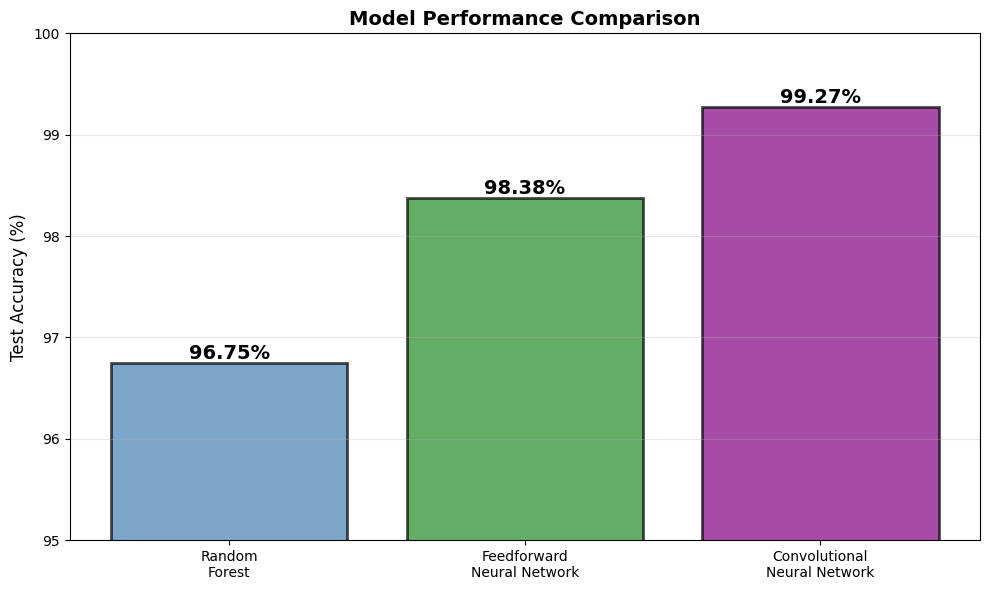


Best Model: CNN with 99.27% accuracy
Improvement over baseline: +2.52%
CNN uses 69.48% fewer parameters than Feedforward NN


In [162]:
print("="*80)
print("MODEL COMPARISON")
print("="*80)

# Visualize accuracy comparison
plt.figure(figsize=(10, 6))
models = ['Random\nForest', 'Feedforward\nNeural Network', 'Convolutional\nNeural Network']
accuracies = [rf_accuracy * 100, nn_accuracy * 100, cnn_accuracy * 100]
colors = ['steelblue', 'forestgreen', 'purple']

bars = plt.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim([95, 100])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest Model: CNN with {cnn_accuracy*100:.2f}% accuracy")
print(f"Improvement over baseline: +{(cnn_accuracy - rf_accuracy)*100:.2f}%")
print(f"CNN uses {(nn_parameters - cnn_parameters)/nn_parameters*100:.2f}% fewer parameters than Feedforward NN")

## 7. Edge Cases and Error Handling
Let's test various edge cases to ensure robustness.

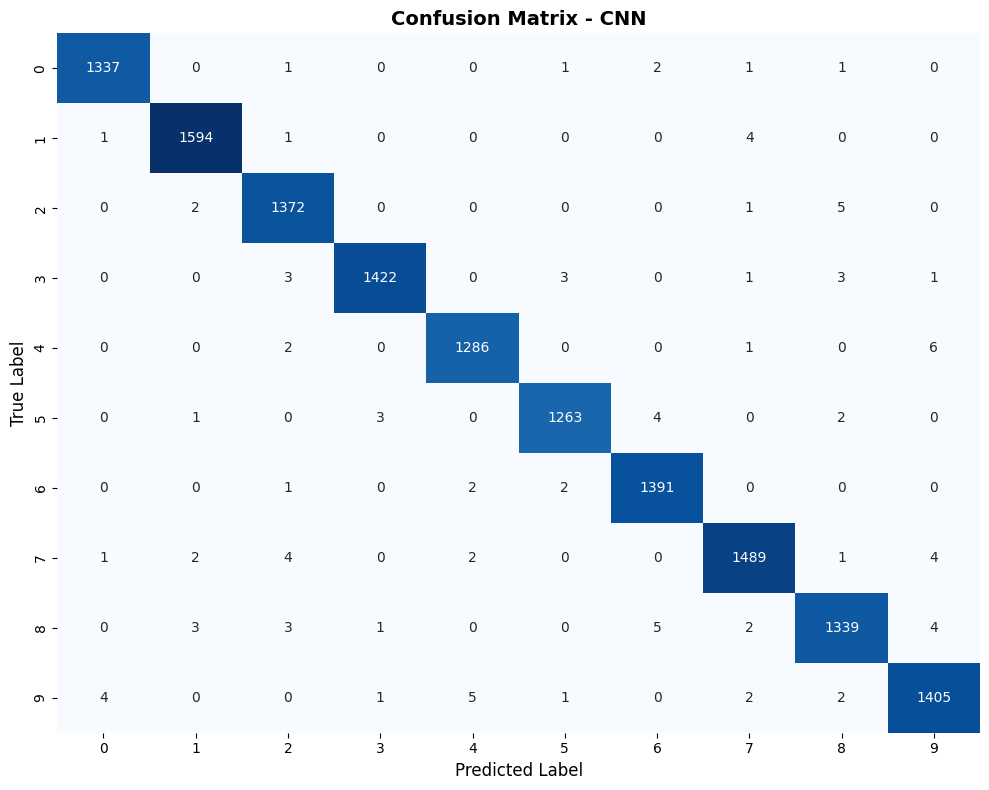

In [163]:
# Confusion Matrix for CNN
cm = confusion_matrix(y_test, cnn_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - CNN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

From the confusion matrix, we observe that the most frequent misclassification occurs between the digits 9 and 4. This confusion likely arises from their structural similarity — the digit 4 can be perceived as a variant of 9 with sharper angles and less curvature. The model occasionally fails to capture these subtle geometric distinctions, leading to overlapping feature representations in the learned space.


True label: 8

Predictions with increasing noise:
Noise Level     Random Forest   Feedforward NN  CNN            
------------------------------------------------------------
Starting prediction...
Prediction complete
Starting prediction...
Prediction complete
0.1             8               8               8              
Starting prediction...
Prediction complete
Starting prediction...
Prediction complete
0.3             8               8               8              
Starting prediction...
Prediction complete
Starting prediction...
Prediction complete
0.5             8               8               8              
Starting prediction...
Prediction complete
Starting prediction...
Prediction complete
0.7             8               2               2              
Starting prediction...
Prediction complete
Starting prediction...
Prediction complete
0.9             8               5               5              


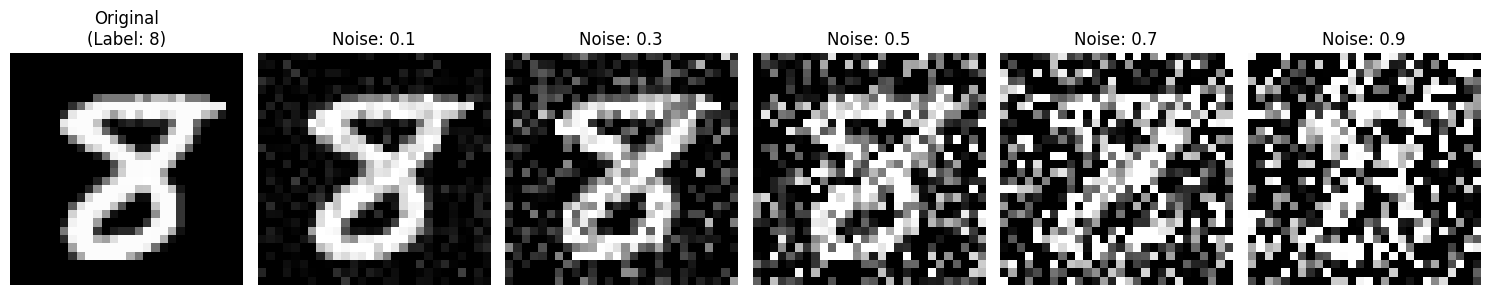

In [170]:
# Get a real digit and add heavy noise
sample_idx = 0
clean_image = X_test[sample_idx] if isinstance(X_test, np.ndarray) else X_test.iloc[sample_idx].values
true_label = y_test[sample_idx] if isinstance(y_test, np.ndarray) else y_test.iloc[sample_idx]

# Add Gaussian noise
noise_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
fig, axes = plt.subplots(1, len(noise_levels) + 1, figsize=(15, 3))

# Show original
axes[0].imshow(clean_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f'Original\n(Label: {true_label})')
axes[0].axis('off')

print(f"\nTrue label: {true_label}")
print("\nPredictions with increasing noise:")
print(f"{'Noise Level':<15} {'Random Forest':<15} {'Feedforward NN':<15} {'CNN':<15}")
print("-" * 60)

for idx, noise_level in enumerate(noise_levels):
    # Add noise
    noise = np.random.normal(0, noise_level, clean_image.shape)
    noisy_image = np.clip(clean_image + noise, 0, 1)
    
    # Visualize
    axes[idx + 1].imshow(noisy_image.reshape(28, 28), cmap='gray')
    axes[idx + 1].set_title(f'Noise: {noise_level}')
    axes[idx + 1].axis('off')
    
    # Predict (just reshape into (1, 784) array)
    noisy_sample = noisy_image.reshape(1, -1)
    noisy_sample_cnn = noisy_image.reshape(1, 1, 28, 28)
    rf_pred = rf_classifier.predict(noisy_sample)[0]
    nn_pred = predict_nn(noisy_sample_cnn)[0]
    cnn_pred = predict_cnn(noisy_sample)[0]

    print(f"{noise_level:<15} {rf_pred:<15} {nn_pred:<15} {cnn_pred:<15}")

plt.tight_layout()
plt.show()


## 8. Conclusion

1. **Model Performance:**
   - Random Forest: 96.75% (baseline, fast training)
   - Feedforward NN: 98.38% (+1,63% improvement)
   - CNN: 99.27% (+2.52% improvement, best overall)

2. **Efficiency:**
   - CNN achieves best accuracy with 69.48% fewer parameters than Feedforward NN
   - Early stopping prevents overfitting and saves training time

3. **Training Techniques**:
   - Early stopping prevents overfitting
   - Learning rate scheduling improves convergence
   - Batch normalization stabilizes training
   - Dropout regularization reduces overfitting
   - Gradient clipping prevents exploding gradients

4. **Robustness:**
   All models demonstrate strong robustness when handling noisy inputs. Even at moderate noise levels, their predictions remain mostly consistent. However, at the highest noise level (0.9), performance begins to degrade — especially for the neural networks, which occasionally confuse similar digits such as 4 and 9 due to blurred edges and loss of fine details.
   Interestingly, the Random Forest model maintained stable predictions across all noise levels, showing remarkable resistance to visual distortion compared to the neural approaches.
   
5. **Error Analysis:**
   - CNN misclassifies only 0.73% of test samples (109/14,000)
   - Errors typically occur on ambiguous or poorly written digits
   - Similar-looking digits (4 vs 9, 3 vs 5) are main confusion sources

6. **Practical Considerations:**
   - Random Forest: Best for quick baseline, no GPU needed
   - Feedforward NN: Good balance of accuracy and simplicity
   - CNN: Best accuracy, recommended for production use

### Recommendations:

 - Use CNN for highest accuracy requirements
 -Use Feedforward NN for balanced performance
 - Use Random Forest for quick prototyping without GPU
 - Always normalize input data to [0, 1] range
